Stocks correlation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_sales_and_features(sales_path, features_path):
    sales_df = pd.read_csv(sales_path)
    features_df = pd.read_csv(features_path)

    sales_df['Date'] = pd.to_datetime(sales_df['Date'])
    sales_df['Week_Start'] = sales_df['Date'] - pd.to_timedelta(sales_df['Date'].dt.weekday, unit='D')
    weekly_sales = sales_df.groupby('Week_Start')['Sum of Invoiced Amount EUR'].sum().reset_index()
    weekly_sales.rename(columns={'Week_Start': 'Date', 'Sum of Invoiced Amount EUR': 'Weekly_Sales'}, inplace=True)

    features_df['Date'] = pd.to_datetime(features_df['Date'])
    weekly_sales['Date'] = pd.to_datetime(weekly_sales['Date'])

    merged = weekly_sales.merge(features_df, on='Date', how='left')
    return merged


d:\School\ITU\Coding\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def load_residuals_with_features(residuals_path, features_path):
    residuals_df = pd.read_csv(residuals_path, header=None, names=["Date", 'Weekly_Sales'])
    residuals_df['Date'] = pd.to_datetime(residuals_df['Date'])
    features_df = pd.read_csv(features_path)
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    merged = residuals_df.merge(features_df, on='Date', how='left')
    merged = merged.drop(index=0)
    return merged.dropna()


In [3]:
def generate_lagged_sales_targets(df, target_col='Weekly_Sales', lags=12):
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(-lag)
    return df


In [4]:
def compute_feature_sales_correlations(df, lags=12, target_prefix='Weekly_Sales'):
    correlation_results = {}
    for lag in range(1, lags + 1):
        lagged_col = f'{target_prefix}_lag_{lag}'
        temp_corr = df.dropna().corr()[lagged_col].drop(lagged_col)
        correlation_results[f'lag_{lag}'] = temp_corr
    return pd.DataFrame(correlation_results)


In [5]:
def get_best_lag_correlations(correlation_df, threshold=0.3):
    results = []

    for feature in correlation_df.index:
        row = correlation_df.loc[feature].dropna()
        if row.empty:
            continue
        best_lag = row.abs().idxmax()
        best_corr = row[best_lag]
        if abs(best_corr) >= threshold:
            results.append({
                "feature": feature,
                "best_lag": best_lag,
                "correlation": best_corr,
                "abs_correlation": abs(best_corr)
            })

    return pd.DataFrame(results).sort_values(by="abs_correlation", ascending=False)


In [6]:
def create_selected_lagged_features(features_df):
    df = features_df.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    lag_config = {
        'STMN.SW_rolling_mean': 1,
        'HSIC_rolling_mean': 3,
        'STMN.SW_rolling_vol': 1,
        'XRAY_rolling_mean': 11
    }

    lagged_features = {'Date': df['Date']}
    for feature, lag in lag_config.items():
        if feature in df.columns:
            lagged_features[f'{feature}_lag{lag}'] = df[feature].shift(lag)
        else:
            print(f"Warning: {feature} not found in DataFrame")

    return pd.DataFrame(lagged_features)


In [7]:
def plot_correlation_heatmap(correlation_df):
    plt.figure(figsize=(12, 6))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation of Market Features with Future Sales (by Lag)')
    plt.show()


In [14]:
def run_feature_correlation_pipeline():
    # Step 1: Load and align residuals with features
    merged_df = load_residuals_with_features("Working_df/residuals.csv", "Working_df/Competitors.csv")

    # Step 2: Generate shifted targets (future sales lags)
    merged_df = generate_lagged_sales_targets(merged_df, target_col='Weekly_Sales', lags=12)

    # Step 3: Compute lagged correlation matrix
    correlation_df = compute_feature_sales_correlations(merged_df, lags=12)

    # Step 4: Visualize correlation heatmap
    plot_correlation_heatmap(correlation_df)

    # Step 5: Extract top features by lag
    top_lagged_features = get_best_lag_correlations(correlation_df, threshold=0.15)
    print(top_lagged_features)

    # Step 6: Create and export selected features
    features_df = pd.read_csv("Working_df/Competitors.csv")
    selected_lagged_df = create_selected_lagged_features(features_df)
    selected_lagged_df.to_csv("Working_df/Selected_lagged_features.csv", index=False)
    print("Lagged market features saved to Working_df/Selected_lagged_features.csv")


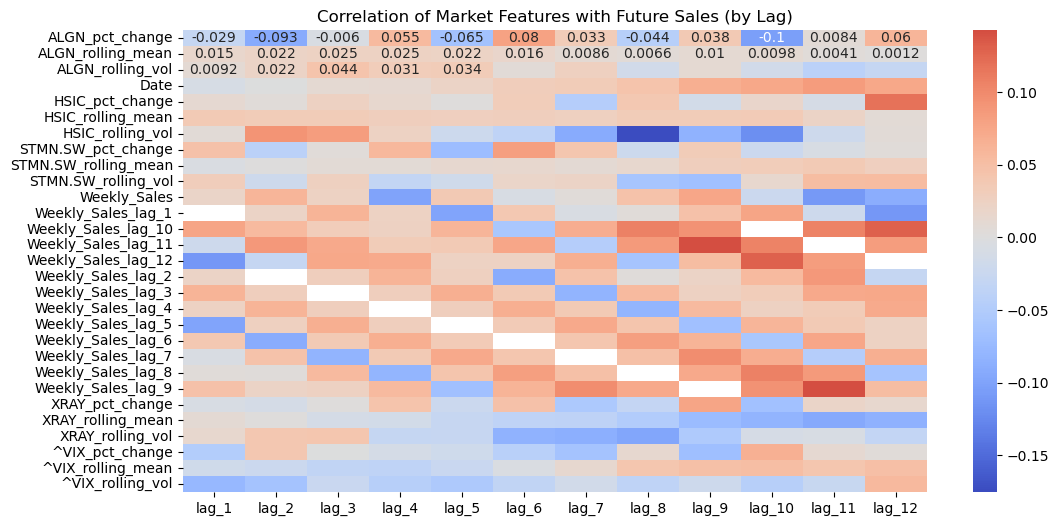

            feature best_lag  correlation  abs_correlation
0  HSIC_rolling_vol    lag_8    -0.175449         0.175449
Lagged market features saved to Working_df/Selected_lagged_features.csv


In [15]:
run_feature_correlation_pipeline()

Clients stock

In [ ]:
import pandas as pd

# Read the Excel file, skipping the first 6 rows
df = pd.read_excel("202504 - Deployement numbers.xlsx", skiprows=6)

# Drop the 'Country' column (if it exists)
df = df.drop(columns=['Country.Country Sub Region Name'], errors='ignore')

# Drop columns after 'SumYTD'
if 'SumYTD' in df.columns:
    end_col_idx = df.columns.get_loc('SumYTD') + 1
    df = df.iloc[:, :end_col_idx]

# Convert the date column
df['MonthDay_WithYear'] = pd.to_datetime(df['MonthDay_WithYear'], errors='coerce')

# Rename for consistency
df = df.rename(columns={'MonthDay_WithYear': 'deployment_date'})

# Preview result
print(df.head())


C:\Users\danii\AppData\Local\Temp\ipykernel_10636\887248107.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MonthDay_WithYear'] = pd.to_datetime(df['MonthDay_WithYear'], errors='coerce')


  deployment_date  Customer.Customer Code  Item.Item Code  SumYTD
0      2016-12-01                  100091        22001201       1
1      2016-12-01                  100223        22001071       1
2      2016-12-01                  101112        22002050       1
3      2016-12-01                  100082        22001090       4
4      2016-12-01                  100082        22001131       1


In [ ]:
def simulate_running_customer_stock(sales_df, deployments_df):
    # Prepare copies and standardize keys
    sales_df = sales_df.copy()
    deployments_df = deployments_df.copy()

    for df in [sales_df, deployments_df]:
        df['Customer.Customer Code'] = df['Customer.Customer Code'].astype(str)
        df['item_code'] = df['item_code'].astype(str)

    deployments_df = deployments_df.dropna(subset=['deployment_date'])

    sales_df = sales_df.sort_values(by=['Customer.Customer Code', 'item_code', 'week_start']).reset_index(drop=True)
    deployments_df = deployments_df.sort_values(by=['Customer.Customer Code', 'item_code', 'deployment_date'])

    sales_df['customer_stock'] = float('nan')

    grouped_sales = sales_df.groupby(['Customer.Customer Code', 'item_code'])
    grouped_deploy = deployments_df.groupby(['Customer.Customer Code', 'item_code'])

    for key, group in grouped_sales:
        cust, item = key
        sales_rows = group.copy()
        deployments = grouped_deploy.get_group(key) if key in grouped_deploy.groups else pd.DataFrame(columns=['deployment_date', 'SumYTD'])

        stock = 0
        dep_index = 0
        deploy_queue = []

        for idx in sales_rows.index:
            sale_date = sales_df.at[idx, 'week_start']
            qty_sold = sales_df.at[idx, 'Sum of Invoiced Qty']

            # Queue deployments before this sale date
            while dep_index < len(deployments) and deployments.iloc[dep_index]['deployment_date'] <= sale_date:
                deploy_queue.append(deployments.iloc[dep_index]['SumYTD'])
                dep_index += 1

            # Apply all queued deployments now
            while deploy_queue:
                stock -= deploy_queue.pop(0)

            # Add the current sale
            stock += qty_sold

            # Save stock (clipped at 0)
            sales_df.at[idx, 'customer_stock'] = max(stock, 0)

    return sales_df


In [ ]:
import pandas as pd

# Load sales data
sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv", parse_dates=["week_start", "last_renewal_week"])

# Prepare deployment data (you already cleaned this into `df`)
deployments_df = df.copy()
deployments_df = deployments_df.iloc[:, :4]
deployments_df.columns = ['deployment_date', 'Customer.Customer Code', 'item_code', 'SumYTD']
deployments_df['deployment_date'] = pd.to_datetime(deployments_df['deployment_date'])

# Run stock simulation
sales_with_stock = simulate_running_customer_stock(sales_df, deployments_df)

# Preview result
print(sales_with_stock[['week_start', 'Customer.Customer Code', 'item_code', 'Sum of Invoiced Qty', 'customer_stock']].head())


C:\Users\danii\AppData\Local\Temp\ipykernel_10636\555899627.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv", parse_dates=["week_start", "last_renewal_week"])


  week_start Customer.Customer Code item_code  Sum of Invoiced Qty  \
0 2017-12-18                 100000  10009724                  1.0   
1 2021-04-05                 100000  80220916                  0.0   
2 2017-02-27                 100000  80240001                  1.0   
3 2017-03-06                 100000  80240001                  1.0   
4 2017-03-27                 100000  80240001                  2.0   

   customer_stock  
0             1.0  
1             0.0  
2             1.0  
3             2.0  
4             4.0  


In [ ]:
sales_with_stock.to_csv("Working_df/Actuals_with_stock.csv", index=False)

In [ ]:
def count_unique_customer_item_combinations(df, customer_col='Customer.Customer Code', item_col='item_code'):
    unique_combinations = df[[customer_col, item_col]].drop_duplicates()
    return len(unique_combinations)


In [ ]:
import pandas as pd
sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv")

d:\School\ITU\Coding\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\danii\AppData\Local\Temp\ipykernel_5516\240597306.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv")


In [ ]:
num_combinations = count_unique_customer_item_combinations(sales_df)
print(f"Unique (customer, item) combinations: {num_combinations}")


🧮 Unique (customer, item) combinations: 170766


In [ ]:
print(sales_df.head())

   year  week  week_start Customer.Customer Code item_code  \
0  2017    51  2017-12-18                 100000  10009724   
1  2021    14  2021-04-05                 100000  80220916   
2  2017     9  2017-02-27                 100000  80240001   
3  2017    10  2017-03-06                 100000  80240001   
4  2017    13  2017-03-27                 100000  80240001   

   Sum of Invoiced Amount EUR  Sum of Invoiced Qty      Country.Country Name  \
0                         0.0                  1.0  United States of America   
1                         0.0                  0.0  United States of America   
2                      1200.0                  1.0  United States of America   
3                      1200.0                  1.0  United States of America   
4                      2400.0                  2.0  United States of America   

      Item.Sales Model item_suffix  ...  is_subscription  is_new_sale  \
0  Production Sub Type         NaN  ...                0            0   


In [16]:
import pandas as pd

def load_and_clean_deployment_data(filepath):
    df = pd.read_excel(filepath, skiprows=6)

    # Drop unneeded region info
    df = df.drop(columns=['Country.Country Sub Region Name'], errors='ignore')

    # Retain columns only up to SumYTD
    if 'SumYTD' in df.columns:
        end_col_idx = df.columns.get_loc('SumYTD') + 1
        df = df.iloc[:, :end_col_idx]

    # Parse and rename date column
    df['MonthDay_WithYear'] = pd.to_datetime(df['MonthDay_WithYear'], errors='coerce')
    df = df.rename(columns={'MonthDay_WithYear': 'deployment_date'})

    return df


In [17]:
def simulate_running_customer_stock(sales_df, deployments_df):
    sales_df = sales_df.copy()
    deployments_df = deployments_df.copy()

    for df in [sales_df, deployments_df]:
        df['Customer.Customer Code'] = df['Customer.Customer Code'].astype(str)
        df['item_code'] = df['item_code'].astype(str)

    deployments_df = deployments_df.dropna(subset=['deployment_date'])

    sales_df = sales_df.sort_values(by=['Customer.Customer Code', 'item_code', 'week_start']).reset_index(drop=True)
    deployments_df = deployments_df.sort_values(by=['Customer.Customer Code', 'item_code', 'deployment_date'])

    sales_df['customer_stock'] = float('nan')
    grouped_sales = sales_df.groupby(['Customer.Customer Code', 'item_code'])
    grouped_deploy = deployments_df.groupby(['Customer.Customer Code', 'item_code'])

    for key, group in grouped_sales:
        cust, item = key
        sales_rows = group.copy()
        deployments = grouped_deploy.get_group(key) if key in grouped_deploy.groups else pd.DataFrame(columns=['deployment_date', 'SumYTD'])

        stock = 0
        dep_index = 0
        deploy_queue = []

        for idx in sales_rows.index:
            sale_date = sales_df.at[idx, 'week_start']
            qty_sold = sales_df.at[idx, 'Sum of Invoiced Qty']

            while dep_index < len(deployments) and deployments.iloc[dep_index]['deployment_date'] <= sale_date:
                deploy_queue.append(deployments.iloc[dep_index]['SumYTD'])
                dep_index += 1

            while deploy_queue:
                stock -= deploy_queue.pop(0)

            stock += qty_sold
            sales_df.at[idx, 'customer_stock'] = max(stock, 0)

    return sales_df


In [18]:
def count_unique_customer_item_combinations(df, customer_col='Customer.Customer Code', item_col='item_code'):
    unique_combinations = df[[customer_col, item_col]].drop_duplicates()
    return len(unique_combinations)


In [19]:
def run_customer_stock_simulation_pipeline():
    # Step 1: Load and clean deployment Excel
    deployment_df = load_and_clean_deployment_data("202504 - Deployement numbers.xlsx")
    
    # Step 2: Load weekly actuals with enriched features
    sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv", parse_dates=["week_start", "last_renewal_week"])

    # Step 3: Prepare deployment table
    deployments_df = deployment_df.copy()
    deployments_df = deployments_df.iloc[:, :4]
    deployments_df.columns = ['deployment_date', 'Customer.Customer Code', 'item_code', 'SumYTD']
    deployments_df['deployment_date'] = pd.to_datetime(deployments_df['deployment_date'])

    # Step 4: Run stock simulation
    sales_with_stock = simulate_running_customer_stock(sales_df, deployments_df)

    # Step 5: Save enriched output
    sales_with_stock.to_csv("Working_df/Actuals_with_stock.csv", index=False)
    print("Saved enriched sales with customer stock to Working_df/Actuals_with_stock.csv")

    # Step 6: Diagnostics
    unique_pairs = count_unique_customer_item_combinations(sales_df)
    print(f"Unique (customer, item) combinations: {unique_pairs}")


In [20]:
run_customer_stock_simulation_pipeline()

C:\Users\danii\AppData\Local\Temp\ipykernel_16028\4071381338.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MonthDay_WithYear'] = pd.to_datetime(df['MonthDay_WithYear'], errors='coerce')
C:\Users\danii\AppData\Local\Temp\ipykernel_16028\2956847482.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_df = pd.read_csv("Working_df/Actuals_all_enriched.csv", parse_dates=["week_start", "last_renewal_week"])


Saved enriched sales with customer stock to Working_df/Actuals_with_stock.csv
Unique (customer, item) combinations: 170766
